# Wharton Analytics Fellows Data Challenge (Spring 2025)

*Raafae Zaki*


# Introduction

In this notebook, we will be analyzing the characteristics of small businesses that have taken loans to determine the chance that they default on repayment. By examining the relationships between the businesses themselves, macroeconomic trends, and the terms of the loans, we can understand how these factors affect the likelihood of a small business defaulting. We can then extend this understanding to build and evaluate predictive models that can estimate the charge off amount of a loan and whether or not the borrower will default.

The first step will be exploratory data analysis (EDA), where we clean and wrangle the data before performing some preliminary analyses on the cleaned dataset. This is where we will produce some visualizations to examine any trends or unique findings in the data as is.

Then we will build a regression model to predict the amount charged off by performing data pre-processing, feature engineering, and then using Gradient Boosting Regressor, a typically robust and powerful model. After evaluating model performance, we will perform hyperparameter tuning as needed to further enhance predictive power.

Lastly, we will build a classification model to predict likelihood of a borrower to default. This process will follow the same workflow as the regression model workflow mentioned above. For this we will use XGBoost for it's robustness and high predictive capability.

# Configuration

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
loan_df = pd.read_csv('loan_data.csv')

<ipython-input-28-1d8168b2f81e>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_df = pd.read_csv('loan_data.csv')


# EDA

## Cleaning

In [ ]:
loan_df.head()

,BORROWER_NAME,CITY,STATE,ZIP,BANK,BANK_STATE,INDUSTRY_ID,APPROVAL_DATE,APPROVAL_YEAR,TERM,...,TREASURY_YIELD,CPI_INDEX,GDP,MORTGAGE_30_US_FIXED,UNRATE,INDPRO_INDEX,UMCSENT_INDEX,CSUSHPINSA_INDEX,CP_INDEX,FEDFUNDS_RATE
0,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,84,...,6.3525,160.525,8577.5525,7.598846,4.941667,80.56905,103.216667,85.317417,592.26625,5.46
1,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,60,...,6.3525,160.525,8577.5525,7.598846,4.941667,80.56905,103.216667,85.317417,592.26625,5.46
2,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,180,...,6.3525,160.525,8577.5525,7.598846,4.941667,80.56905,103.216667,85.317417,592.26625,5.46
3,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,60,...,6.3525,160.525,8577.5525,7.598846,4.941667,80.56905,103.216667,85.317417,592.26625,5.46
4,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,240,...,6.3525,160.525,8577.5525,7.598846,4.941667,80.56905,103.216667,85.317417,592.26625,5.46


In [ ]:
loan_df.shape # View initial shape of dataframe

(899164, 36)

In [ ]:
loan_df_clean = loan_df.copy() # Create new dataframe for cleaning

loan_df_clean.dropna(how='all', inplace=True) # Drop any rows that entirely empty (keep partially empty ones)

loan_df_clean.info(verbose = True) # Display types and number of non-null rows for each column after dropping null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   BORROWER_NAME         899150 non-null  object 
 1   CITY                  899134 non-null  object 
 2   STATE                 899150 non-null  object 
 3   ZIP                   899164 non-null  int64  
 4   BANK                  897605 non-null  object 
 5   BANK_STATE            897598 non-null  object 
 6   INDUSTRY_ID           899164 non-null  int64  
 7   APPROVAL_DATE         899164 non-null  object 
 8   APPROVAL_YEAR         899164 non-null  object 
 9   TERM                  899164 non-null  int64  
 10  EMPLOYEE_COUNT        899164 non-null  int64  
 11  IS_NEW                899028 non-null  float64
 12  JOBS_CREATED_COUNT    899164 non-null  int64  
 13  JOBS_RETAINED_COUNT   899164 non-null  int64  
 14  FRANCHISE_CODE        899164 non-null  int64  
 15  

In [ ]:
loan_df_clean.shape # View new shape of dataframe -- no change from dropping completely missing rows

(899164, 36)

In [ ]:
loan_df_clean.drop_duplicates(inplace=True) # Drop redundant rows
loan_df_clean.reset_index(drop = True, inplace=True) # Reset index

In [ ]:
loan_df_clean.shape # View new shape of dataframe -- dropped 128 duplicate rows

(899036, 36)

In [ ]:
# Convert columns containing dollar values from string object type to a numeric float type for dowstream modeling

dollar_cols = ['DISBURSEMENT_AMOUNT', 'BALANCE_AMOUNT', 'CHARGE_OFF_AMOUNT', 'LOAN_AMOUNT', 'SBA_APPROVED_AMOUNT']

loan_df_clean[dollar_cols] = loan_df_clean[dollar_cols].apply(lambda col: col.str.replace('[\$,]', '', regex=True).str.strip()) # Remove $ symbol first
loan_df_clean[dollar_cols] = loan_df_clean[dollar_cols].astype(float) # Then cast to float type

loan_df_clean[dollar_cols].head() # Check if change was applied

,DISBURSEMENT_AMOUNT,BALANCE_AMOUNT,CHARGE_OFF_AMOUNT,LOAN_AMOUNT,SBA_APPROVED_AMOUNT
0,60000.0,0.0,0.0,60000.0,48000.0
1,40000.0,0.0,0.0,40000.0,32000.0
2,287000.0,0.0,0.0,287000.0,215250.0
3,35000.0,0.0,0.0,35000.0,28000.0
4,229000.0,0.0,0.0,229000.0,229000.0


In [ ]:
# Convert date columns to date type

date_cols = ['APPROVAL_DATE', 'DEFAULT_DATE', 'DISBURSEMENT_DATE']
loan_df_clean[date_cols] = loan_df_clean[date_cols].apply(pd.to_datetime, errors='coerce') # can ignore warnings, let Pandas parse dates automatically

loan_df_clean[date_cols].head() # Check if change was applied

<ipython-input-68-59a3fb2c30d0>:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-68-59a3fb2c30d0>:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-68-59a3fb2c30d0>:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,APPROVAL_DATE,DEFAULT_DATE,DISBURSEMENT_DATE
0,1997-02-28,NaT,1999-02-28
1,1997-02-28,NaT,1997-05-31
2,1997-02-28,NaT,1997-12-31
3,1997-02-28,NaT,1997-06-30
4,1997-02-28,NaT,1997-05-14


In [ ]:
loan_df_clean[loan_df_clean['DEFAULT_DATE'].notna()]['DEFAULT_DATE'].head() # Confirm if default date rows with dates still exist

,DEFAULT_DATE
6,1991-06-24
36,2002-04-18
43,1989-10-04
58,2014-06-26
60,2005-10-04


In [ ]:
# Clean APPROVAL_YEAR column to remove any values containing letters and convert to numeric float type

loan_df_clean['APPROVAL_YEAR'] = loan_df_clean['APPROVAL_YEAR'].str.extract('(\d+)').astype(float)

## Wrangling

In [ ]:
# Create IS_DEFAULT column based on value of DEFAULT_DATE -- this will act as our target variable (label) during classification

loan_df_clean['IS_DEFAULT'] = np.where(loan_df_clean['DEFAULT_DATE'].notna(), 1, 0)

loan_df_clean['IS_DEFAULT'].head()

,IS_DEFAULT
0,0
1,0
2,0
3,0
4,0


In [ ]:
# Create year columns for default date and disbursement date

loan_df_clean['DEFAULT_YEAR'] = loan_df_clean['DEFAULT_DATE'].dt.year
loan_df_clean['DISBURSEMENT_YEAR'] = loan_df_clean['DISBURSEMENT_DATE'].dt.year
loan_df_clean['APPROVAL_YEAR'] = loan_df_clean['APPROVAL_DATE'].dt.year # current approval year column is missing a lot of values

loan_df_clean[['DISBURSEMENT_DATE', 'DISBURSEMENT_YEAR']].head() # Confirm

,DISBURSEMENT_DATE,DISBURSEMENT_YEAR
0,1999-02-28,1999.0
1,1997-05-31,1997.0
2,1997-12-31,1997.0
3,1997-06-30,1997.0
4,1997-05-14,1997.0


In [ ]:
# Create INDUSTRY_SECTOR column to categorize the industry of each business using INDUSTRY_ID and corresponding codes from data dictionary
# This can act as an additional feature during the downstream modeling process

industry_dict = {

    '0' : 'Unknown',
    '11' : 'Agriculture, forestry, fishing and hunting',
    '21' : 'Mining, quarrying, and oil and gas extraction',
    '22' : 'Utilities',
    '23' : 'Construction',
    '31' : 'Manufacturing',
    '32' : 'Manufacturing',
    '33' : 'Manufacturing',
    '42' : 'Wholesale trade',
    '44' : 'Retail trade',
    '45' : 'Retail trade',
    '48' : 'Transportation and warehousing',
    '49' : 'Transportation and warehousing',
    '51' : 'Information',
    '52' : 'Finance and insurance',
    '53' : 'Real estate and rental and leasing',
    '54' : 'Professional, scientific, and technical services',
    '55' : 'Management of companies and enterprises',
    '56' : 'Administrative and support and waste management and remediation services',
    '61' : 'Educational services',
    '62' : 'Health care and social assistance',
    '71' : 'Arts, entertainment, and recreation',
    '72' : 'Accommodation and food services',
    '81' : 'Other services',
    '92' : 'Public administration'
}


loan_df_clean['INDUSTRY_SECTOR'] = loan_df_clean['INDUSTRY_ID'].astype(str).str[:2].map(industry_dict) # Map the first 2 digits only to industry_dict

loan_df_clean[['INDUSTRY_ID', 'INDUSTRY_SECTOR']].head() # Confirm

,INDUSTRY_ID,INDUSTRY_SECTOR
0,451120,Retail trade
1,722410,Accommodation and food services
2,621210,Health care and social assistance
3,0,Unknown
4,0,Unknown


In [ ]:
# Create LOAN_SBA_RATIO column  comapring the amount loaned to the amount approved by the SBA

loan_df_clean['LOAN_SBA_RATIO'] = loan_df_clean['LOAN_AMOUNT'] / loan_df_clean['SBA_APPROVED_AMOUNT']
loan_df_clean['LOAN_SBA_RATIO'] = loan_df_clean['LOAN_SBA_RATIO'].replace([np.inf, -np.inf], np.nan)

loan_df_clean['LOAN_SBA_RATIO'].head() # Confirm

,LOAN_SBA_RATIO
0,1.250000
1,1.250000
2,1.333333
3,1.250000
4,1.000000


## Analysis

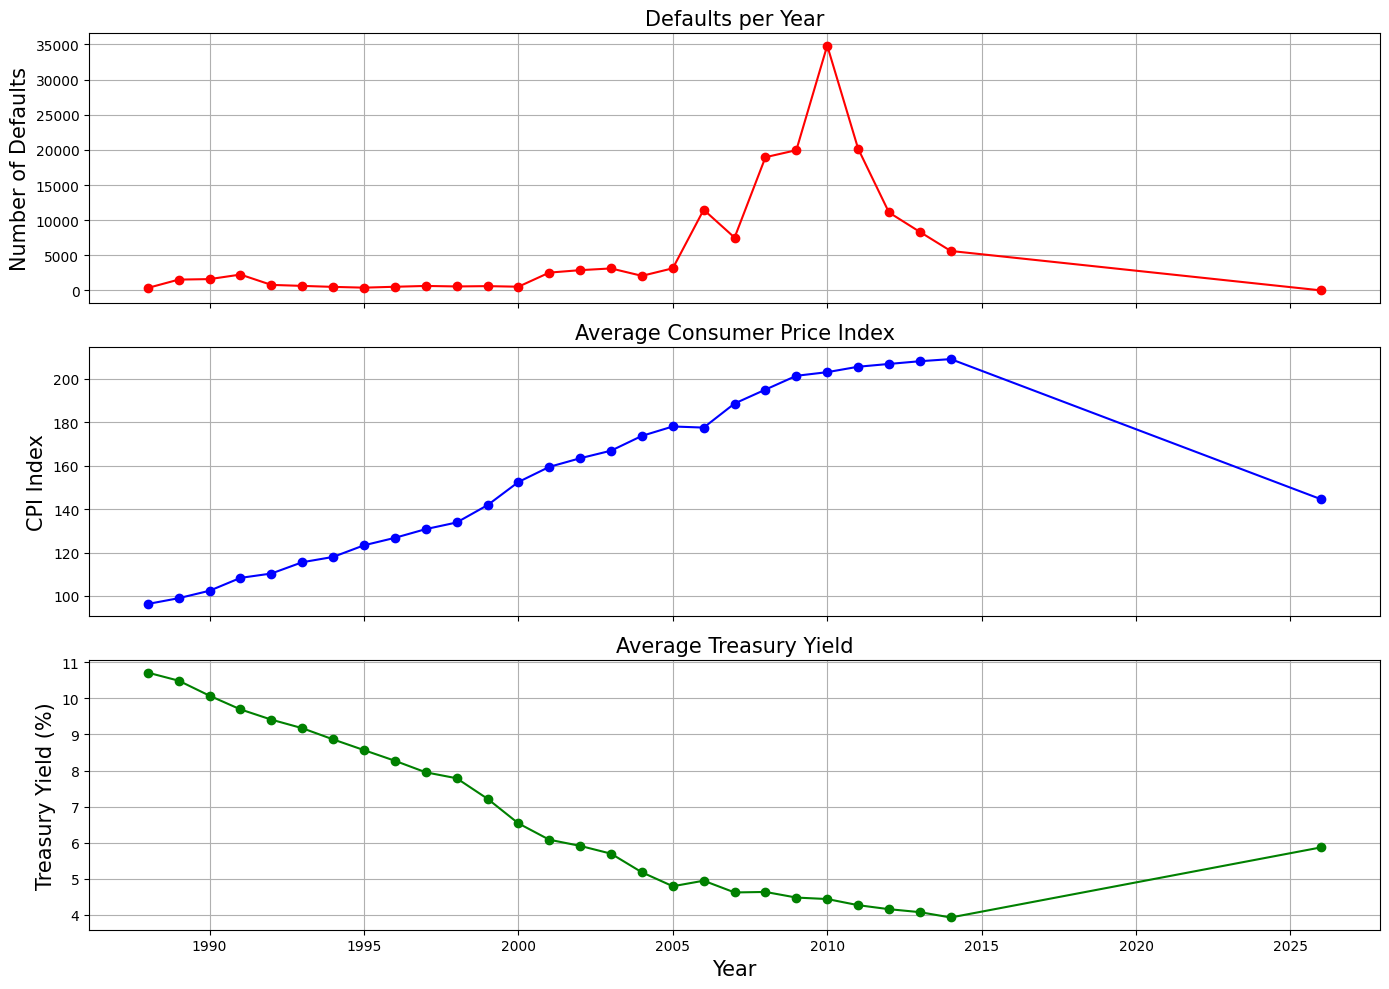

In [ ]:
# Analyze total number of defaults each year

default_by_year = loan_df_clean.groupby(loan_df_clean["DEFAULT_YEAR"])["IS_DEFAULT"].sum().reset_index()
cpi_by_year = loan_df_clean.groupby(loan_df_clean["DEFAULT_YEAR"])["CPI_INDEX"].mean().reset_index()
treasury_yield_by_year = loan_df_clean.groupby(loan_df_clean["DEFAULT_YEAR"])["TREASURY_YIELD"].mean().reset_index()


fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot Defaults per Year
axes[0].plot(default_by_year["DEFAULT_YEAR"], default_by_year["IS_DEFAULT"], marker="o", color="r")
axes[0].set_title("Defaults per Year", fontsize=15)
axes[0].set_ylabel("Number of Defaults", fontsize=15)
axes[0].grid()

# Plot Average Consumer Price Index
axes[1].plot(cpi_by_year["DEFAULT_YEAR"], cpi_by_year["CPI_INDEX"], marker="o", color="b")
axes[1].set_title("Average Consumer Price Index", fontsize=15)
axes[1].set_ylabel("CPI Index", fontsize=15)
axes[1].grid()

# Plot Average Treasury Yield
axes[2].plot(treasury_yield_by_year["DEFAULT_YEAR"], treasury_yield_by_year["TREASURY_YIELD"], marker="o", color="g")
axes[2].set_title("Average Treasury Yield", fontsize=15)
axes[2].set_xlabel("Year", fontsize=15)
axes[2].set_ylabel("Treasury Yield (%)", fontsize=15)
axes[2].grid()


plt.tight_layout()
plt.show()

<ipython-input-129-711f0970fcb5>:4: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-129-711f0970fcb5>:5: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




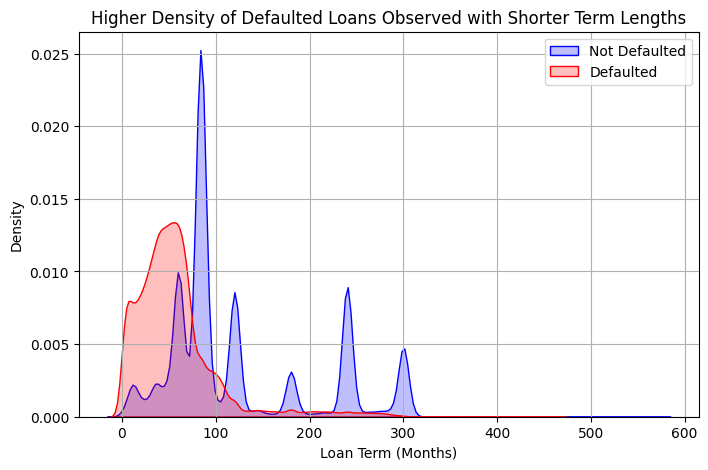

In [ ]:
# Analyze the distribution of loan terms and compare between defaulted and non-defaulted loans

plt.figure(figsize=(8, 5))
sns.kdeplot(loan_df_clean[loan_df_clean['IS_DEFAULT'] == 0]['TERM'], label="Not Defaulted", shade=True, color="blue")
sns.kdeplot(loan_df_clean[loan_df_clean['IS_DEFAULT'] == 1]['TERM'], label="Defaulted", shade=True, color="red")

plt.xlabel("Loan Term (Months)")
plt.ylabel("Density")
plt.title("Higher Density of Defaulted Loans Observed with Shorter Term Lengths")

plt.legend()
plt.grid()

plt.show()

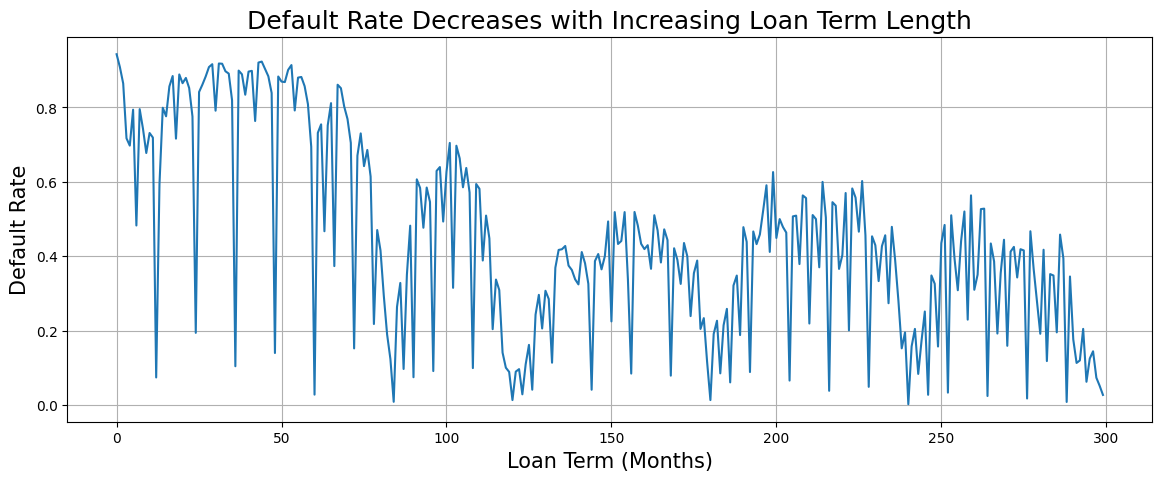

In [ ]:
# Analyze the relationship between loan term and default rate

term_default_rate = loan_df_clean.groupby('TERM')['IS_DEFAULT'].mean().reset_index().head(300)

plt.figure(figsize=(14, 5))
plt.plot(term_default_rate['TERM'], term_default_rate['IS_DEFAULT'])
plt.title("Default Rate Decreases with Increasing Loan Term Length", fontsize=18)
plt.xlabel("Loan Term (Months)", fontsize=15)
plt.ylabel("Default Rate", fontsize=15)
plt.grid()

plt.show()

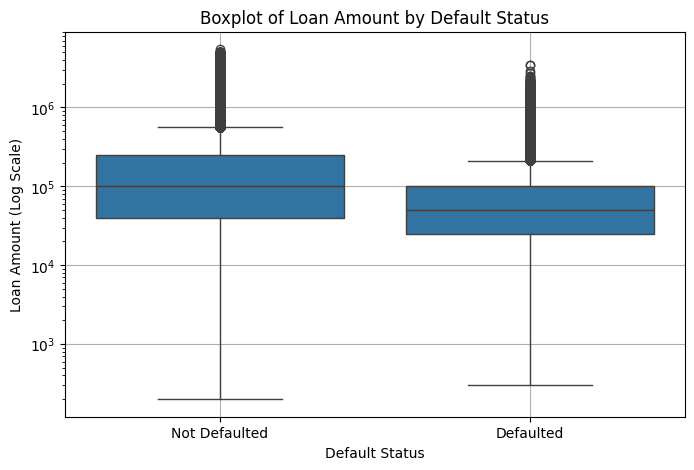

In [ ]:
# Analyze differences in loan amounts for defaulted vs. non-defaulted loans

plt.figure(figsize=(8, 5))
sns.boxplot(x="IS_DEFAULT", y="LOAN_AMOUNT", data=loan_df_clean)

plt.yscale("log")
plt.xticks([0, 1], ["Not Defaulted", "Defaulted"])
plt.xlabel("Default Status")
plt.ylabel("Loan Amount (Log Scale)")
plt.title("Boxplot of Loan Amount by Default Status")
plt.grid()

plt.show()

In [ ]:
# Analyze all states by default rate (accounts for number of companies in each state)

state_companies = loan_df_clean.groupby('STATE')['BORROWER_NAME'].nunique().reset_index()
state_defaults = loan_df_clean.groupby('STATE')['IS_DEFAULT'].sum().reset_index()

state_default_rate = state_defaults.merge(state_companies, on='STATE')  # Merge number of companies with number of defaults per state
state_default_rate['DEFAULT_RATE'] = state_default_rate['IS_DEFAULT'] / state_default_rate['BORROWER_NAME']  # Calculate default rate by state


state_default_rate = state_default_rate.sort_values(by='DEFAULT_RATE', ascending=False)
fig = px.choropleth(state_default_rate, locations="STATE", locationmode="USA-states",
                    color="DEFAULT_RATE", color_continuous_scale="Reds",
                    scope="usa", title="Default Rates by State")

fig.show()

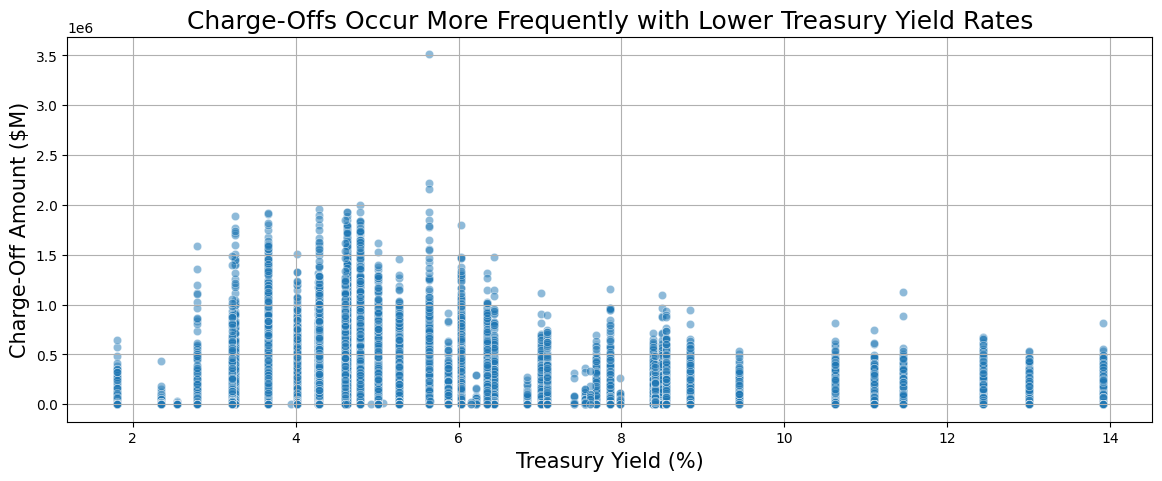

In [ ]:
# Analyze how treasury yields impact charge-off amounts

plt.figure(figsize=(14,5))
sns.scatterplot(x=loan_df_clean["TREASURY_YIELD"], y=loan_df_clean["CHARGE_OFF_AMOUNT"], alpha=0.5)
plt.xlabel("Treasury Yield (%)", fontsize=15)
plt.ylabel("Charge-Off Amount ($M)", fontsize=15)
plt.title("Charge-Offs Occur More Frequently with Lower Treasury Yield Rates", fontsize=18)
plt.grid()

plt.show()

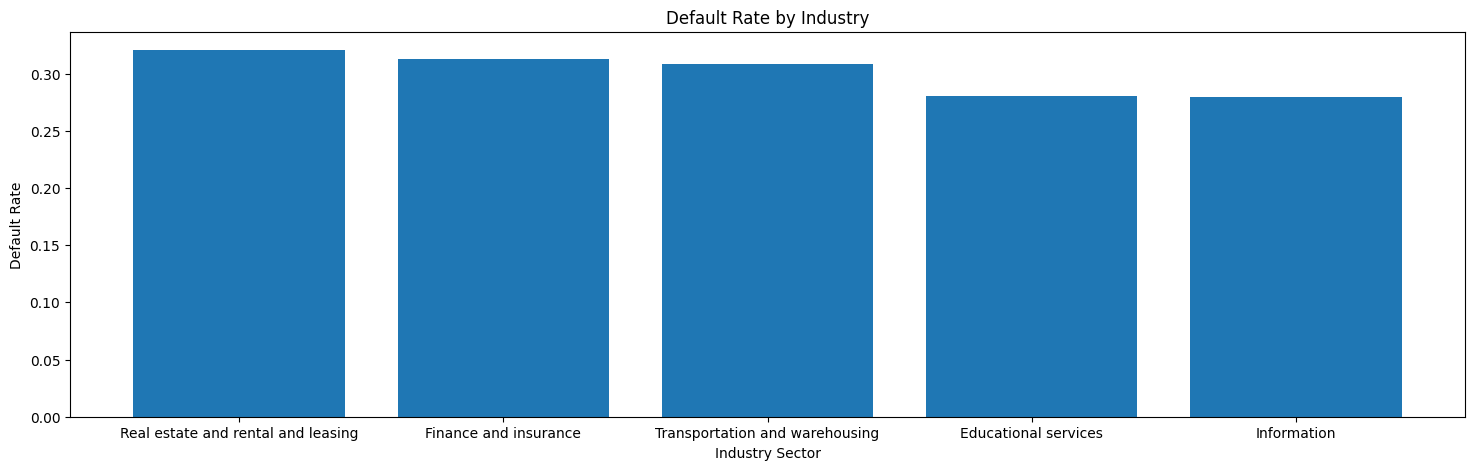

In [ ]:
# Analyze top 5 industries by default rate (accounts for number of companies in each industry)

industry_companies = loan_df_clean.groupby('INDUSTRY_SECTOR')['BORROWER_NAME'].nunique().reset_index()
industry_defaults = loan_df_clean.groupby('INDUSTRY_SECTOR')['IS_DEFAULT'].sum().reset_index()

industry_default_rate = industry_defaults.merge(industry_companies, on='INDUSTRY_SECTOR') # Merge number of companies with number of defaults on industry sector
industry_default_rate['DEFAULT_RATE'] = industry_default_rate['IS_DEFAULT'] / industry_default_rate['BORROWER_NAME'] # Calculate default rate by industry sector

industry_default_rate = industry_default_rate.sort_values(by='DEFAULT_RATE', ascending=False).head(5) # Top 5



plt.figure(figsize=(18, 5))
plt.bar(industry_default_rate["INDUSTRY_SECTOR"], industry_default_rate["DEFAULT_RATE"])
plt.title("Default Rate by Industry")
plt.xlabel("Industry Sector")
plt.ylabel("Default Rate")
plt.show()

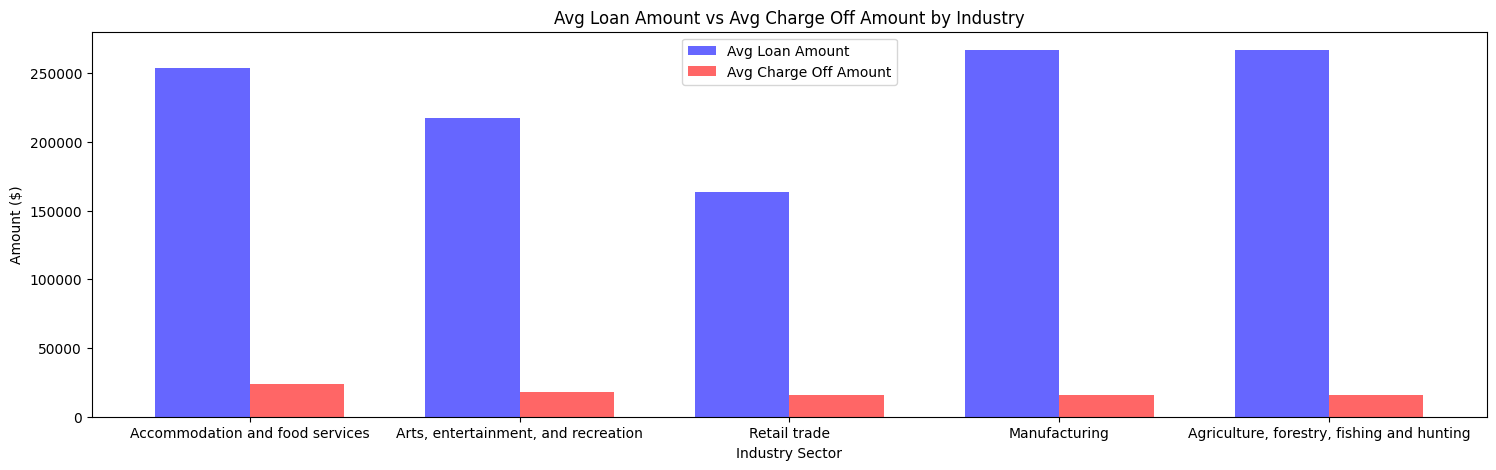

In [ ]:
# Analyze top 5 industries by highest charge-off amount

industry_loans = loan_df_clean.groupby('INDUSTRY_SECTOR')['LOAN_AMOUNT'].mean().reset_index()
industry_charge_offs = loan_df_clean.groupby('INDUSTRY_SECTOR')['CHARGE_OFF_AMOUNT'].mean().reset_index()

industry_summary = industry_loans.merge(industry_charge_offs, on='INDUSTRY_SECTOR') # Merge loan and charge-off amounts
industry_summary = industry_summary.sort_values(by='CHARGE_OFF_AMOUNT', ascending=False).head(5) # Top 5 by charge-off amount

fig, ax = plt.subplots(figsize=(18, 5))
x = np.arange(len(industry_summary))

ax.bar(x - 0.35/2, industry_summary["LOAN_AMOUNT"], 0.35, label="Avg Loan Amount", color='blue', alpha=0.6)
ax.bar(x + 0.35/2, industry_summary["CHARGE_OFF_AMOUNT"], 0.35, label="Avg Charge Off Amount", color='r', alpha=0.6)

ax.set_xticks(x)
ax.set_xticklabels(industry_summary["INDUSTRY_SECTOR"])
ax.set_xlabel("Industry Sector")
ax.set_ylabel("Amount ($)")
ax.set_title("Avg Loan Amount vs Avg Charge Off Amount by Industry")
ax.legend()

plt.show()

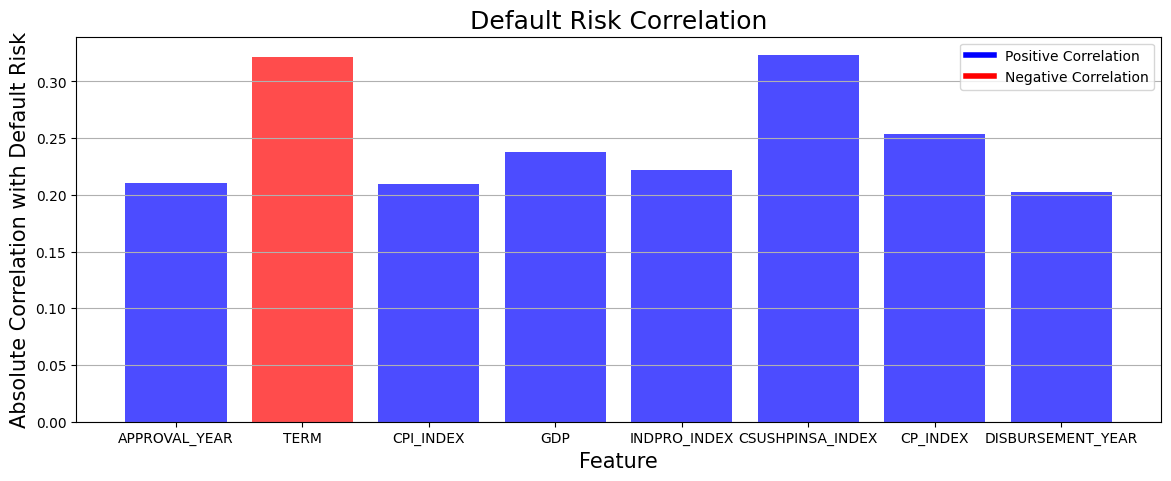

In [ ]:
# Correlation analysis between numeric features

num_cols = loan_df_clean.select_dtypes(include=['float', 'int']).columns.tolist()
correlation_matrix = loan_df_clean[num_cols].corr()
filtered_corr = correlation_matrix[(correlation_matrix > 0.2) | (correlation_matrix < -0.2)]
filtered_corr = filtered_corr.loc[['IS_DEFAULT'], ~correlation_matrix.columns.isin(['IS_DEFAULT', 'CHARGE_OFF_AMOUNT'])]

filtered_corr = filtered_corr.T.reset_index()
filtered_corr.columns = ['Feature', 'Correlation']
filtered_corr['Absolute Correlation'] = filtered_corr['Correlation'].abs()
filtered_corr = filtered_corr.dropna(subset=['Correlation'])

colors = ['red' if corr < 0 else 'blue' for corr in filtered_corr['Correlation']]

plt.figure(figsize=(14, 5))
bars = plt.bar(filtered_corr['Feature'], filtered_corr['Absolute Correlation'], color=colors, alpha=0.7)

plt.title('Default Risk Correlation', fontsize=18)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Absolute Correlation with Default Risk', fontsize=15)
plt.grid(axis='y')

plt.legend(
    handles=[
        plt.Line2D([0], [0], color='blue', lw=4, label='Positive Correlation'),
        plt.Line2D([0], [0], color='red', lw=4, label='Negative Correlation')],
    loc='upper right')

plt.show()

In [ ]:
loan_df_clean.shape

(899036, 41)

# Regression

## Data Pre-processing & Feature Engineering

In [ ]:
# Create new dataset specifically for regression

loan_df_model = loan_df_clean.copy()

loan_df_model.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899036 entries, 0 to 899035
Data columns (total 41 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   BORROWER_NAME         899022 non-null  object        
 1   CITY                  899006 non-null  object        
 2   STATE                 899022 non-null  object        
 3   ZIP                   899036 non-null  int64         
 4   BANK                  897478 non-null  object        
 5   BANK_STATE            897471 non-null  object        
 6   INDUSTRY_ID           899036 non-null  int64         
 7   APPROVAL_DATE         899036 non-null  datetime64[ns]
 8   APPROVAL_YEAR         899036 non-null  int32         
 9   TERM                  899036 non-null  int64         
 10  EMPLOYEE_COUNT        899036 non-null  int64         
 11  IS_NEW                898900 non-null  float64       
 12  JOBS_CREATED_COUNT    899036 non-null  int64         
 13 

In [ ]:
# Convert values in binary_cols to only include 0 or 1

binary_cols = [col for col in loan_df_model.columns if col.startswith('IS_')]
conversion_map = {'1': 1, '0': 0, 'Y': 1, 'N': 0}

for col in binary_cols:

    if col == 'IS_NEW':
        loan_df_model[col] = loan_df_model[col].replace({2: 0, 1: 1})
    else:
        loan_df_model[col] = pd.to_numeric(loan_df_model[col].replace(conversion_map), errors='coerce')


    loan_df_model = loan_df_model[loan_df_model[col].isin([0, 1])] # Drop rows with invalid values (not 0 or 1) and NaN

    loan_df_model[col] = loan_df_model[col].astype(int) # Convert to integer type

<ipython-input-87-6b72c2db83c3>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-87-6b72c2db83c3>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-87-6b72c2db83c3>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-87-6b72

In [ ]:
loan_df_model['IS_LOW_DOC'].unique()

array([1, 0])

In [ ]:
loan_df_model.shape

(772075, 41)

Pre-processing the binary columns resulted in some rows of data being lost, but this will result in a cleaner dataset for the model with less confusion/errors due to binary columns containing values other than 0 or 1.

**Feature Selection**

In [ ]:
loan_df_model.columns

Index(['BORROWER_NAME', 'CITY', 'STATE', 'ZIP', 'BANK', 'BANK_STATE',
       'INDUSTRY_ID', 'APPROVAL_DATE', 'APPROVAL_YEAR', 'TERM',
       'EMPLOYEE_COUNT', 'IS_NEW', 'JOBS_CREATED_COUNT', 'JOBS_RETAINED_COUNT',
       'FRANCHISE_CODE', 'IS_URBAN', 'IS_REVOLVER', 'IS_LOW_DOC',
       'DEFAULT_DATE', 'DISBURSEMENT_DATE', 'DISBURSEMENT_AMOUNT',
       'BALANCE_AMOUNT', 'LOAN_STATUS', 'CHARGE_OFF_AMOUNT', 'LOAN_AMOUNT',
       'SBA_APPROVED_AMOUNT', 'TREASURY_YIELD', 'CPI_INDEX', 'GDP',
       'MORTGAGE_30_US_FIXED', 'UNRATE', 'INDPRO_INDEX', 'UMCSENT_INDEX',
       'CSUSHPINSA_INDEX', 'CP_INDEX', 'FEDFUNDS_RATE', 'IS_DEFAULT',
       'DEFAULT_YEAR', 'DISBURSEMENT_YEAR', 'INDUSTRY_SECTOR',
       'LOAN_SBA_RATIO'],
      dtype='object')

In [ ]:
relevant_features = [
    'CHARGE_OFF_AMOUNT',         # Target variable
    'LOAN_AMOUNT',
    'LOAN_SBA_RATIO',
    'TERM',
    'EMPLOYEE_COUNT',
    'IS_URBAN',
    'IS_NEW',
    'IS_LOW_DOC',
    'IS_REVOLVER',
    'APPROVAL_YEAR',
    'DISBURSEMENT_YEAR',
    'DISBURSEMENT_AMOUNT',
    'INDUSTRY_SECTOR',
    'UNRATE',
    'GDP',
    'FEDFUNDS_RATE'
]


loan_df_model = loan_df_model[relevant_features].dropna().reset_index(drop=True)

Key predictors of charge-off amount include loan size and disbursement features (e.g., loan amount, disbursement, amount, SBA-approved ratio) since they directly influence potential losses. Time-based factors (approval year, disbursement year) capture economic conditions at different loan stages. Borrower characteristics (employee count, industry type) provide insight into repayment capacity. Loan structure factors (low documentation status, revolving credit) highlight risk exposure. Macroeconomic indicators (unemployment rate, GDP, Fed funds rate, inflation measures) reflect external financial conditions impacting defaults. If we want to predict charge-offs at loan origination, then we should remove any features that wouldn’t be known at that time (e.g., BALANCE_AMOUNT, DEFAULT_YEAR).

**Encoding Categorical Features**

In [ ]:
categorical_features = loan_df_model.select_dtypes(include=['object', 'category']).columns.tolist()

# Create copy of the data set for encoding
encoded_df = loan_df_model.copy()

# Apply OHE to the categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)

encoded_values = pd.DataFrame(encoder.fit_transform(encoded_df[categorical_features]),
                              columns=encoder.get_feature_names_out(categorical_features))


# Replace the original nominal columns with the encoded ones
encoded_df = encoded_df.drop(categorical_features, axis=1)
encoded_df = pd.concat([encoded_df, encoded_values], axis=1)

encoded_df.head()

,CHARGE_OFF_AMOUNT,LOAN_AMOUNT,LOAN_SBA_RATIO,TERM,EMPLOYEE_COUNT,IS_URBAN,IS_NEW,IS_LOW_DOC,IS_REVOLVER,APPROVAL_YEAR,...,"INDUSTRY_SECTOR_Mining, quarrying, and oil and gas extraction",INDUSTRY_SECTOR_Other services,"INDUSTRY_SECTOR_Professional, scientific, and technical services",INDUSTRY_SECTOR_Public administration,INDUSTRY_SECTOR_Real estate and rental and leasing,INDUSTRY_SECTOR_Retail trade,INDUSTRY_SECTOR_Transportation and warehousing,INDUSTRY_SECTOR_Unknown,INDUSTRY_SECTOR_Utilities,INDUSTRY_SECTOR_Wholesale trade
0,0.0,60000.0,1.250000,84,4,0,0,1,0,1997,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,40000.0,1.250000,60,2,0,0,1,0,1997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,287000.0,1.333333,180,7,0,1,0,0,1997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,35000.0,1.250000,60,2,0,1,1,0,1997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,229000.0,1.000000,240,14,0,1,0,0,1997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


**Train-Test Split**

In [ ]:
# Set random seed
seed = 4281964


# Split data into train and test sets
X = encoded_df.drop(columns = ['CHARGE_OFF_AMOUNT']) # everything but our target variable (CHARGE_OFF_AMOUNT)
y = encoded_df['CHARGE_OFF_AMOUNT'] # only our target variable



X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.15,
                                                    random_state = seed,
                                                    shuffle = True)

## Modeling

We will use GradientBoostingRegressor() due to its high predictive power. This is because it is an ensemble method employing iterative gradient descent to minimize residual error with each iteration.

In [ ]:
# Initialize model

gbr = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=seed
)

# Fit to the training dataset
gbr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, random_state=4281964)

In [ ]:
# Predict using model
y_train_pred = gbr.predict(X_train)
y_test_pred = gbr.predict(X_test)

# Compute error metrics
training_mse = mean_squared_error(y_train, y_train_pred)
testing_mse = mean_squared_error(y_test, y_test_pred)

training_mae = mean_absolute_error(y_train, y_train_pred)
testing_mae = mean_absolute_error(y_test, y_test_pred)

training_r2 = r2_score(y_train, y_train_pred)
testing_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f'Regression Model Training MSE: {training_mse:.2f}')
print(f'Regression Model Testing MSE: {testing_mse:.2f}')

print(f'Regression Model Training MAE: {training_mae:.2f}')
print(f'Regression Model Testing MAE: {testing_mae:.2f}')

print(f'Regression Model Training R²: {training_r2:.2f}')
print(f'Regression Model Testing R²: {testing_r2:.2f}')

Regression Model Training MSE: 2532068608.68
Regression Model Testing MSE: 2682782856.42
Regression Model Training MAE: 15249.57
Regression Model Testing MAE: 15407.33
Regression Model Training R²: 0.44
Regression Model Testing R²: 0.42


The model has relatively poor performance, as seen by the middling testing R^2 score (42% variance explained by the model) and the high mean squared and mean absolute error values, all of which are typical metrics used for evaluating regression models. The high error observed may be due to the general difficulty of building accurate regression models since they have to predict continuos values. This requires much more precision since there is a lack of clear decision boundaries, such as with classification.

But we can still use this model to examine the relative importance of each feature, which can give insight into which factors are most impactful in determining the charge-off amount. We will then perform hyperparameter tuning to try and improve our predictive performance as much as possible (given time and compute constraints).

In [ ]:
feature_importance = pd.Series(gbr.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)
feature_importance

,0
TERM,0.516660
LOAN_AMOUNT,0.154960
GDP,0.071621
DISBURSEMENT_AMOUNT,0.064518
LOAN_SBA_RATIO,0.046385
UNRATE,0.038475
DISBURSEMENT_YEAR,0.038174
APPROVAL_YEAR,0.036993
EMPLOYEE_COUNT,0.009834
IS_URBAN,0.007827


The feature importance table for this classification model highlights the significance of both loan characteristics and broader economic conditions in predicting default. Loan term stands out as the strongest predictor, indicating that repayment duration plays a critical role in default risk. Loan amount, disbursement amount, and the SBA-guaranteed ratio further emphasize the impact of financial exposure on a borrower's ability to repay. Compared to regression-based predictions, this model places slightly more weight on macroeconomic indicators such as GDP and unemployment rate, reinforcing the idea that economic conditions influence default likelihood. The inclusion of approval and disbursement years also suggests that the timing of a loan, relative to economic cycles, affects repayment outcomes. Borrower-specific factors like employee count and urban location play a smaller role but still contribute to assessing business stability and resilience.

## Hyperparameter Tuning

In [ ]:
# Define the cross-validation splitter with the given seed
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

# Define the GradientBoostingRegressor with the given seed
estimator = GradientBoostingRegressor(random_state=seed)


param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None],
    'loss': ['squared_error', 'absolute_error']
}


# Set up the randomized search
gbr_search = RandomizedSearchCV(estimator=estimator,
                                param_distributions=param_dist,
                                scoring='neg_mean_squared_error',
                                cv=cv,
                                n_iter=7,  # Number of random combinations to test
                                random_state=seed,
                                verbose=2)

# Execute the search by calling fit
gbr_search.fit(X_train, y_train)

In [ ]:
print("Best parameters found: ", gbr_search.best_params_)

best_gbr = gbr_search.best_estimator_  # Tuned GB model

# Predict using the best model
y_train_pred = best_gbr.predict(X_train)
y_test_pred = best_gbr.predict(X_test)

# Compute error metrics
training_mse = mean_squared_error(y_train, y_train_pred)
testing_mse = mean_squared_error(y_test, y_test_pred)

training_mae = mean_absolute_error(y_train, y_train_pred)
testing_mae = mean_absolute_error(y_test, y_test_pred)

training_r2 = r2_score(y_train, y_train_pred)
testing_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f'Regression Model Training MSE: {training_mse:.2f}')
print(f'Regression Model Testing MSE: {testing_mse:.2f}')

print(f'Regression Model Training MAE: {training_mae:.2f}')
print(f'Regression Model Testing MAE: {testing_mae:.2f}')

print(f'Regression Model Training R²: {training_r2:.2f}')
print(f'Regression Model Testing R²: {testing_r2:.2f}')

Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 4, 'loss': 'squared_error', 'learning_rate': 0.1}
Regression Model Training MSE: 2365506001.05
Regression Model Testing MSE: 2575201421.19
Regression Model Training MAE: 15526.02
Regression Model Testing MAE: 15762.78
Regression Model Training R²: 0.48
Regression Model Testing R²: 0.44


As we can see, hyperparameter tuning led to rather marginal increase in model performance (Testing R^2 went from 42% to 44%).

# Classification

## Data Pre-processing & Feature Engineering

In [ ]:
# Create new dataset specifically for classification

loan_df_model = loan_df_clean.copy()

In [ ]:
# Convert values in binary_cols to only include 0 or 1

binary_cols = [col for col in loan_df_model.columns if col.startswith('IS_')]
conversion_map = {'1': 1, '0': 0, 'Y': 1, 'N': 0}

for col in binary_cols:
    if col == 'IS_NEW':
        loan_df_model[col] = loan_df_model[col].replace({2: 0, 1: 1})
    else:
        # Convert to numeric first (handles mixed types)
        loan_df_model[col] = pd.to_numeric(loan_df_model[col].replace(conversion_map), errors='coerce')

    # Drop rows with invalid values (not 0 or 1) and NaN
    loan_df_model = loan_df_model[loan_df_model[col].isin([0, 1])]

    # Convert to integer type
    loan_df_model[col] = loan_df_model[col].astype(int)

<ipython-input-27-63d28094a5c5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df_model[col] = loan_df_model[col].astype(int)
<ipython-input-27-63d28094a5c5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df_model[col] = loan_df_model[col].astype(int)
<ipython-input-27-63d28094a5c5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [ ]:
loan_df_model.shape

(772075, 41)

**Feature Selection**

In [ ]:
relevant_features = [

    'IS_DEFAULT',        # Target variable
    'IS_NEW',
    'EMPLOYEE_COUNT',
    'INDUSTRY_SECTOR',
    'IS_URBAN',
    'LOAN_AMOUNT',
    'DISBURSEMENT_AMOUNT',
    'LOAN_SBA_RATIO',
    'TERM',
    'IS_LOW_DOC',
    'IS_REVOLVER',
    'APPROVAL_YEAR',
    'TREASURY_YIELD',
    'UNRATE',
    'GDP',
    'FEDFUNDS_RATE',
    'CPI_INDEX',
    'INDPRO_INDEX',
]



loan_df_model = loan_df_model[relevant_features].dropna().reset_index(drop=True)

The relevant features for classifiying potential defaults are similar to those for the regression model, but focusing slightly more on macroeconomic indicators. Borrower-specific characteristics (business age, employee count, industry type) help assess operational stability and repayment capacity. Loan structure factors (loan amount, disbursement amount, SBA-guaranteed ratio, term length, low documentation status, revolving credit) highlight risk exposure. Temporal features (approval year) capture economic conditions at loan origination, while macroeconomic indicators (unemployment rate, GDP, Fed funds rate, inflation measures, industrial production index) reflect broader financial stressors influencing borrower viability. The industry sector helps account for any sector-specific volatility (restaurants vs. manufacturing).

**Encoding Categorical Features**

In [ ]:
categorical_features = loan_df_model.select_dtypes(include=['object', 'category']).columns.tolist()

# Create copy of the data set for encoding
encoded_df = loan_df_model.copy()

# Apply OHE to the categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)

encoded_values = pd.DataFrame(encoder.fit_transform(encoded_df[categorical_features]),
                              columns=encoder.get_feature_names_out(categorical_features))


# Replace the original nominal columns with the encoded ones
encoded_df = encoded_df.drop(categorical_features, axis=1)
encoded_df = pd.concat([encoded_df, encoded_values], axis=1)

encoded_df.head()

,IS_DEFAULT,IS_NEW,EMPLOYEE_COUNT,IS_URBAN,LOAN_AMOUNT,DISBURSEMENT_AMOUNT,LOAN_SBA_RATIO,TERM,IS_LOW_DOC,IS_REVOLVER,...,"INDUSTRY_SECTOR_Mining, quarrying, and oil and gas extraction",INDUSTRY_SECTOR_Other services,"INDUSTRY_SECTOR_Professional, scientific, and technical services",INDUSTRY_SECTOR_Public administration,INDUSTRY_SECTOR_Real estate and rental and leasing,INDUSTRY_SECTOR_Retail trade,INDUSTRY_SECTOR_Transportation and warehousing,INDUSTRY_SECTOR_Unknown,INDUSTRY_SECTOR_Utilities,INDUSTRY_SECTOR_Wholesale trade
0,0,0,4,0,60000.0,60000.0,1.250000,84,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,0,2,0,40000.0,40000.0,1.250000,60,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,7,0,287000.0,287000.0,1.333333,180,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,2,0,35000.0,35000.0,1.250000,60,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,1,14,0,229000.0,229000.0,1.000000,240,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Calculate ratio of class imbalance
class_counts = encoded_df['IS_DEFAULT'].value_counts()
class_ratio = class_counts.max() / class_counts.min()

print(f'Severity has {class_ratio:.2f}x more observations in the majority class ({class_counts.max()}) than the minority ({class_counts.min()}) class.')

Severity has 4.41x more observations in the majority class (538267) than the minority (121960) class.


Fortunately, we don't have a high class-imbalance which should result in better model performance. This also means that we can rely on accuracy as a trustworthy metric (in addition to recall and precision), instead of having to rely on other less intuitive metrics due to bias.

**Train-Test Split**

In [ ]:
# Set random seed
seed = 4281964



# Split data into train and test sets
X = encoded_df.drop(columns = ['IS_DEFAULT']) # everything but our target variable (IS_DEFAULT)
y = encoded_df['IS_DEFAULT'] # only our target variable


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.15,
                                                    random_state = seed,
                                                    shuffle = True)

## Modeling

In [ ]:
# Install older version due to compatibility issues and errors with latest update - only needed for XGBClassifier
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

from xgboost import XGBClassifier

In [ ]:
# Initialize XGBoost Classifier
xgb = XGBClassifier(random_state = seed,
                          tree_method = 'hist',
                          scale_pos_weight = class_ratio, # Using the imbalance ratio we calculated during the pre-processing section
                          n_estimators = 50)



# Fit to the training dataset
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=4281964, ...)

In [ ]:
# Predict using classifier
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)


# Compute metrics
training_accuracy_score = accuracy_score(y_train, y_train_pred)
testing_accuracy_score = accuracy_score(y_test, y_test_pred)

training_recall_score = recall_score(y_train, y_train_pred)
testing_recall_score = recall_score(y_test, y_test_pred)

training_precision_score = precision_score(y_train, y_train_pred)
testing_precision_score = precision_score(y_test, y_test_pred)


# Print results
print(f'XGBoosting Training Accuracy: {training_accuracy_score}')
print(f'XGBoosting Testing Accuracy: {testing_accuracy_score}')

print(f'XGBoosting Training Recall: {training_recall_score}')
print(f'XGBoosting Testing Recall: {testing_recall_score}')

print(f'XGBoosting Training Precision: {training_precision_score}')
print(f'XGBoosting Testing Precision: {testing_precision_score}')

XGBoosting Training Accuracy: 0.9322905529658299
XGBoosting Testing Accuracy: 0.9310849699601151
XGBoosting Training Recall: 0.929751747036794
XGBoosting Testing Recall: 0.9254739594682937
XGBoosting Training Precision: 0.7581978181131244
XGBoosting Testing Precision: 0.756872354644687


As we can see above, the XGBoost Classifier can predict the likelihood of defaulting with approximately 93.1% accuracy, even without hyperparameter tuning (which we will avoid for the sake of time). It also has relatively high recall and precision scores, meaning that it minimizes false negatives just as well (92.5% recall) and false positives decently well (77.7% precision).

Overall, this means that we can accurately predict whether or not a borrower will default on their loan repayment. We also have a good idea about which features impact the likelihood of defaulting the most, as seen in the table below.

In [ ]:
feature_importance = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)
feature_importance

,0
TERM,0.281356
INDPRO_INDEX,0.246414
GDP,0.146105
LOAN_SBA_RATIO,0.059393
APPROVAL_YEAR,0.041839
IS_REVOLVER,0.028301
INDUSTRY_SECTOR_Health care and social assistance,0.020619
LOAN_AMOUNT,0.018394
FEDFUNDS_RATE,0.017198
TREASURY_YIELD,0.013159


The feature importance table for this classification model further confirms the importance of the loan term on whether a borrower will default and what the charge-off amount may be. However, unlike the feature importances for the regression model, this method of estimation seems to rely slightly more on macroeconomic trends as opposed to different aspects of the loan as we saw with the regression feature importances. This is partly due to us including more of such indicators during the feature selection process. Regardless, this further confirms the idea that major economic trends and conditions can greatly impact the likelihood of default as borrowers are subject to adverse economic conditions that can negatively impact the performance of their businesses. Such events increase the likelihood of a borrower being unable to repay their loans. And similar to the regression feature importances, loan is the strongest predictor, confirming the impact of repayment duration on default risk.